### [전이학습] 개 고양이 classification

* 데이터 출처 : https://www.kaggle.com/datasets/aleemaparakatta/cats-and-dogs-mini-dataset

## 1. 환경 설정 및 데이터 준비

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns

# 데이터 경로 설정 (학생들은 자신의 경로로 수정)
BASE_DIR = '../data/cnn_data/dogs_cats/'
train_dir = os.path.join(BASE_DIR, 'train/')
val_dir = os.path.join(BASE_DIR, 'validation/')

# 데이터 증강 및 기본 설정
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 데이터 로드
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    # target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    # target_size=(128, 128),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

print('데이터 준비 완료!')

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
데이터 준비 완료!


## 2. 모델 구성
MobileNetV2, VGG16, ResNet50 중 하나를 선택해 전이학습 모델을 구성합니다.
- MobileNetV2: 경량화, 빠른 학습 (기본 선택)
- VGG16: 단순하고 깊은 구조, 높은 메모리 사용
- ResNet50: 잔차 연결로 깊은 학습 가능, 중간 속도

*실험*: 아래에서 원하는 모델을 선택해 주석을 해제하고 실행해보세요.

In [7]:
# 모델 선택 (기본: MobileNetV2)
# 1. MobileNetV2
image_size = 224    # 128, 150, ...
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_name = 'MobileNetV2'

# # 2. VGG16
# base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# model_name = 'VGG16'

# # 3. ResNet50
# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
# model_name = 'ResNet50'

# 학습 가능 층 설정 (마지막 10개 층만 학습)
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [ ]:

# 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),              # Flatten 대신 사용
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# 모델 컴파일 (낮은 학습률 사용)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 모델 요약
print(f'선택된 모델: {model_name}')
model.summary()

선택된 모델: MobileNetV2


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 896,577 (3.42 MB)

 Non-trainable params: 1,525,504 (5.82 MB)

## 3. 데이터 증강 및 학습

In [9]:
%%time
# 콜백 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=5, 
                               restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(f'best_model_{model_name}.keras', monitor='val_loss', 
                             save_best_only=True, verbose=1)

# 학습
history = model.fit(
    train_generator,
    steps_per_epoch=62,   # 데이터 수 // 배치사이즈
    epochs=20,
    validation_data=validation_generator,
    validation_steps=12,   
    callbacks=[early_stopping, checkpoint]
)

print('학습 완료!')

Epoch 1/20
50/62 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7335 - loss: 0.5462

d:\Users\admin\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from None to 0.07626, saving model to best_model_MobileNetV2.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8338 - loss: 0.3692 - val_accuracy: 0.9740 - val_loss: 0.0763
Epoch 2/20
50/62 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9380 - loss: 0.1690
Epoch 2: val_loss did not improve from 0.07626
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9350 - loss: 0.1630 - val_accuracy: 0.9740 - val_loss: 0.0766
Epoch 3/20
50/62 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.9492 - loss: 0.1218
Epoch 3: val_loss did not improve from 0.07626
62/62 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.9500 - loss: 0.1119 - val_accuracy: 0.9792 - val_loss: 0.0837
Epoch 4/20
50/62 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.9738 - loss: 0.0785
Epoch 4: val_loss did not improve from 0.07626
62/62 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9700 - loss: 0.0799 - val_accuracy: 0.9688 - val_loss: 0.1083
Epoch 5/20
50/62 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - 

## 4. 결과 확인 및 평가

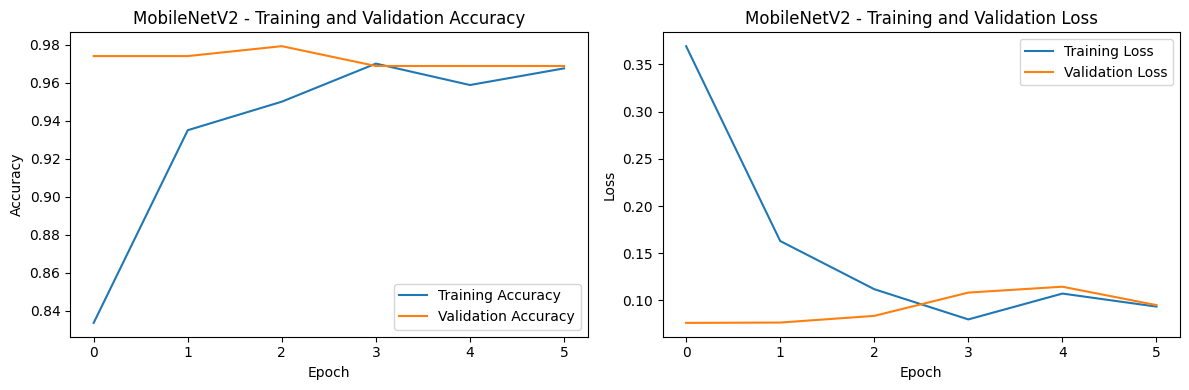

In [10]:
# 정확도와 손실 그래프
plt.figure(figsize=(12, 4))

# 정확도
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title(f'{model_name} - Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 손실
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'{model_name} - Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


* 검증 데이터 로 예측해보기

In [11]:
# 검증 데이터에 대한 예측
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=12)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
y_true = validation_generator.classes[:len(y_pred_classes)]
y_true

12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 362ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

* 혼동 행렬 (Confusion Matrix)

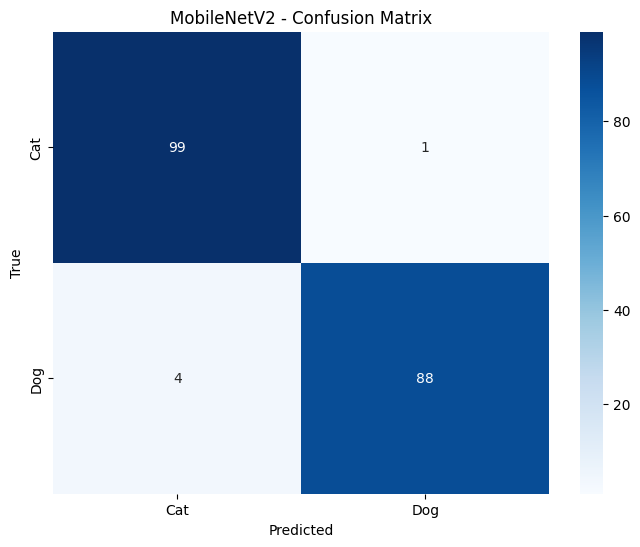

In [12]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title(f'{model_name} - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

* 평가 지표 (Accuracy(정확도), Precision(정밀도), Recall(재현율), F1-Score) 분석

In [13]:
train_generator.class_indices.keys()

dict_keys(['cat', 'dog'])

In [14]:
# Classification Report (Accuracy, Precision, Recall, F1 Score)
report = classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog'])  # train_generator.class_indices.keys()
print(f'{model_name} - Classification Report:')
print(report)

MobileNetV2 - Classification Report:
              precision    recall  f1-score   support

         Cat       0.96      0.99      0.98       100
         Dog       0.99      0.96      0.97        92

    accuracy                           0.97       192
   macro avg       0.97      0.97      0.97       192
weighted avg       0.97      0.97      0.97       192



In [15]:
report

'              precision    recall  f1-score   support\n\n         Cat       0.96      0.99      0.98       100\n         Dog       0.99      0.96      0.97        92\n\n    accuracy                           0.97       192\n   macro avg       0.97      0.97      0.97       192\nweighted avg       0.97      0.97      0.97       192\n'

## 5. 새로운 이미지로 예측해 보기

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
MobileNetV2 - 예측 결과: Cat


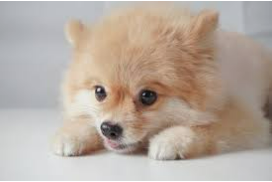

In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

# 예측 함수
def predict_image(model, img_path):
    # img = load_img(img_path, target_size=(128, 128))
    img = load_img(img_path, target_size=(image_size, image_size))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    pred = model.predict(img_array)[0][0]
    return 'Dog' if pred > 0.5 else 'Cat'

# 예시 이미지 예측
sample_img_path = '../data/images/1.png'  # 학생들은 자신의 이미지 경로로 수정
result = predict_image(model, sample_img_path)
print(f'{model_name} - 예측 결과: {result}')

Image.open(sample_img_path)

**[과제]**  
- 자신의 개/고양이 이미지를 모델로 예측해보자.  

- MobileNetV2, VGG16, ResNet50 중 다른 모델을 선택해 학습하고 결과를 비교해보세요
  
**[질문]**
1. 데이터 증강이 모델 성능에 어떤 영향을 미쳤나?  
  
2. 학습 시간이 더 있다면 어떤 변화를 시도할까? (예: 층 추가, 학습률 조정 등)  
3. MobileNetV2, VGG16, ResNet50 중 어떤 모델이 가장 효과적이었나? 이유는?'

#### **새로운 이미지로 예측해 보기**

In [24]:
import numpy as np
from PIL import Image

import glob
img_paths = glob.glob('../cnn_data/images/*.*')
images = []
PIL_images = []
for path in img_paths:
    image = plt.imread(path)
    images.append(image)
    PIL_img = Image.open(path)
    PIL_images.append(PIL_img.resize((image_size, image_size)))
plt.imshow(image)
plt.show()

NameError: name 'image' is not defined

In [25]:
PIL_images

[]

In [ ]:
train_generator.class_indices

In [ ]:
classes = ['냥이', '댕이']
for p_img in PIL_images:
    display(p_img)
    img_arr = np.array(p_img.convert('RGB'))[np.newaxis, :, :, :] / 255.  # 정규화
    predicted = model.predict(img_arr, verbose=0).round(3)[0][0]
    print(predicted, classes[int((predicted > 0.5) * 1)])